In [132]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [133]:
# Extract all the Data

count = [None]*2
rssi = [None]*2
dist = [None]*2
walls = [None]*2
data = [None]*4

band = ['2.4GHz', '5GHz']
ssid = ['wyfy', 'iitmwifi']
colors = ['blue', 'orange']

for i in range(2): # change to range(2) for 5GHz
  count[i] = np.array([], dtype=int)
  rssi[i] = np.array([], dtype=float)
  dist[i] = np.array([], dtype=float)
  walls[i] = np.array([], dtype=int)

  with open('scan_{}_{}.csv'.format(band[i], ssid[i]), mode = 'r') as file:
    csvFile = csv.reader(file)
    for lines in csvFile:    
      count[i] = np.append(count[i], int(lines[0]))
      rssi[i] = np.append(rssi[i], float(lines[1]))
      dist[i] = np.append(dist[i], float(lines[2]))
      walls[i] = np.append(walls[i], int(lines[3]))
  data[i] = [count[i], rssi[i], dist[i], walls[i]]

  # print("Band = {}  SSID = {}".format(band[i], ssid[i]))
  # print(pd.DataFrame(list(zip(*data[i]))))

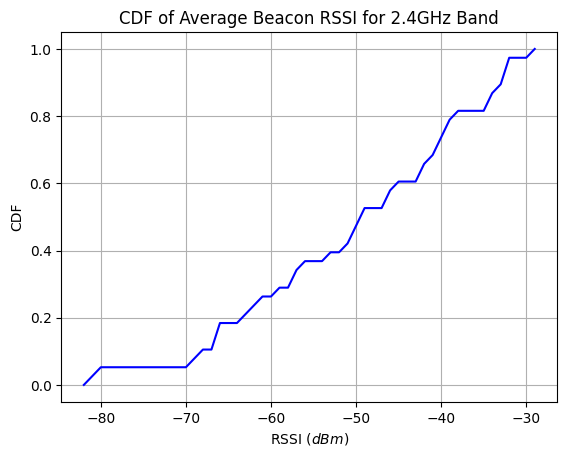

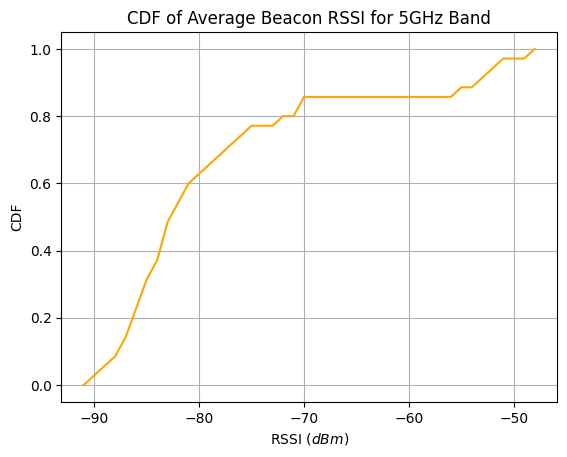

In [175]:
# Calculate the CDF 

sorted_rssi = [None]*2
cdf_rssi = [[], []]
x_range = [[], []]

for i in range(2):
    sorted_rssi[i] = sorted(data[i][1])

    for j in range(int(min(sorted_rssi[i]))-1, int(max(sorted_rssi[i]))+1):
        x_range[i] = np.append(x_range[i], j)
        cdf_rssi[i] = np.append(cdf_rssi[i], sum(rssi_val <= j for rssi_val in sorted_rssi[i]))
    
    norm_cdf_rssi = cdf_rssi[i]/max(cdf_rssi[i])

    plt.plot(x_range[i], norm_cdf_rssi, color=colors[i])
    plt.xlabel('RSSI ($dBm$)')
    plt.ylabel('CDF')
    plt.title('CDF of Average Beacon RSSI for {} Band'.format(band[i]))
    plt.grid()
    plt.show()

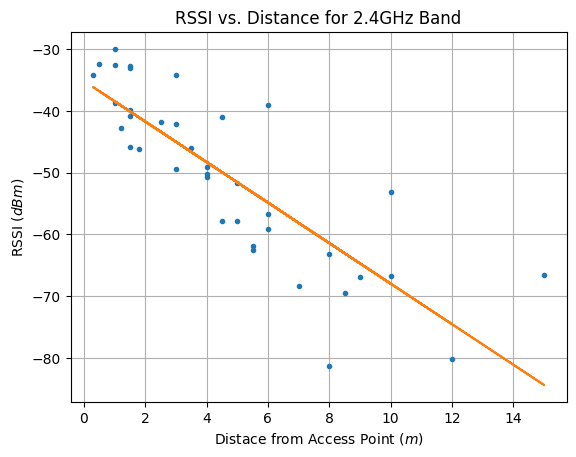

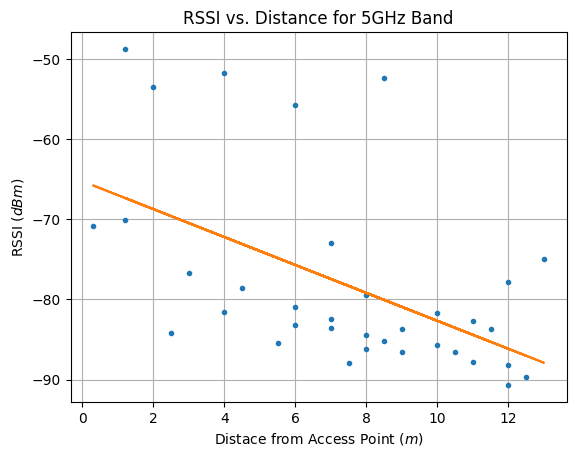

In [159]:
# Relation between RSSI of 2.4GHz and 5GHz bands

for i in range(2):
    slope, inter = np.polyfit(dist[i], rssi[i], deg=1)

    fit = slope*dist[i] + inter
    plt.plot(dist[i], rssi[i], '.')
    plt.plot(dist[i], fit)
    plt.xlabel('Distace from Access Point ($m$)')
    plt.ylabel('RSSI ($dBm$)')
    plt.title('RSSI vs. Distance for {} Band'.format(band[i]))
    plt.grid()
    plt.show()

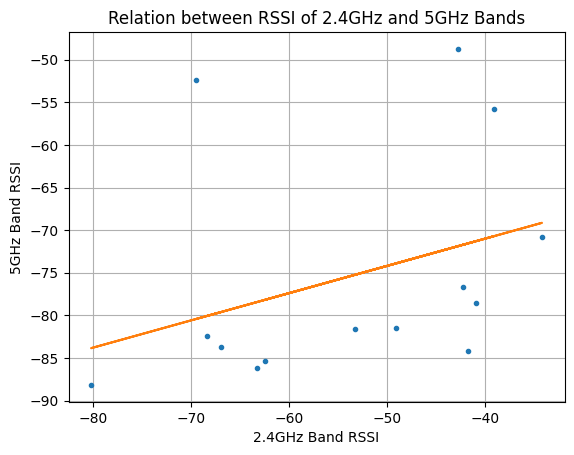

In [160]:
unique_dist = []
unique_dist_rssi = [[], []]

for i in range(len(dist[0])):    
    if (dist[0][i] in (dist[1]) and (dist[0][i] not in unique_dist)): 
        unique_dist.append(dist[0][i])
        unique_dist_rssi[0].append(rssi[0][i])
        unique_dist_rssi[1].append(rssi[1][list(dist[1]).index(dist[0][i])])

# print(unique_dist)
# print(unique_dist_rssi[0])
# print(unique_dist_rssi[1])
        
unique_dist_rssi = np.array(unique_dist_rssi)
        
slope, inter = np.polyfit(unique_dist_rssi[0], unique_dist_rssi[1], deg=1)
fit = slope*unique_dist_rssi[0] + inter
plt.plot(unique_dist_rssi[0], unique_dist_rssi[1], '.')
plt.plot(unique_dist_rssi[0], fit)
plt.xlabel('{} Band RSSI'.format(band[0]))
plt.ylabel('{} Band RSSI'.format(band[1]))
plt.title('Relation between RSSI of {} and {} Bands'.format(band[0], band[1]))
plt.grid()
plt.show()

In [157]:
# Path Loss Relation

def rssi_predictor(vector, RSSIref, path_loss_exp, wall_attenuation_factor):
    distance, num_walls = vector

    return RSSIref + 10 * path_loss_exp * np.log(distance) + wall_attenuation_factor * num_walls

x = []
y = []

for i in range(2):
    x = [dist[i], walls[i]] 
    y = rssi[i]

    x = np.array(x)
    y = np.array(y)

    # print(x)
    # print(y)

    popt, pcov = curve_fit(rssi_predictor, x, y)

    RSSIref, path_loss_exp, wall_attenuation_factor = popt

    print(band[i])
    print(f"{RSSIref=}, {path_loss_exp=}, {wall_attenuation_factor=}")

2.4GHz
RSSIref=-32.48509685127802, path_loss_exp=-0.8996465533422774, wall_attenuation_factor=-5.625593592502653
5GHz
RSSIref=-69.78339958824898, path_loss_exp=-0.7764506257450366, wall_attenuation_factor=16.19328483728891


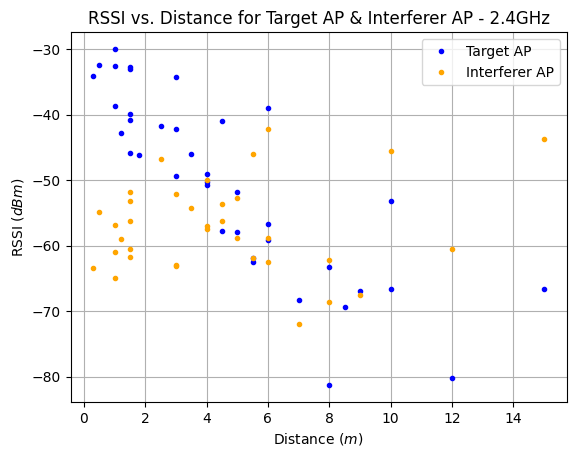

In [186]:
# Compare with interferer APs - 2 GHz

rssi_alt_2 = np.array([], dtype=float)
dist_alt_2 = np.array([], dtype=float)

with open('scan_{}_Nutmeg.csv'.format(band[0]), mode = 'r') as file:
    csvFile = csv.reader(file)
    for lines in csvFile:    
        rssi_alt_2 = np.append(rssi_alt_2, float(lines[1]))
        dist_alt_2 = np.append(dist_alt_2, float(lines[2]))
    data = [rssi_alt_2, dist_alt_2]

plt.plot(dist[0], rssi[0], '.', color='blue')
plt.plot(dist_alt_2, rssi_alt_2, '.', color='orange')
plt.xlabel('Distance ($m$)')
plt.ylabel('RSSI ($dBm$)')
plt.title('RSSI vs. Distance for Target AP & Interferer AP - 2.4GHz')
plt.legend(['Target AP', 'Interferer AP'])
plt.grid()
plt.show()

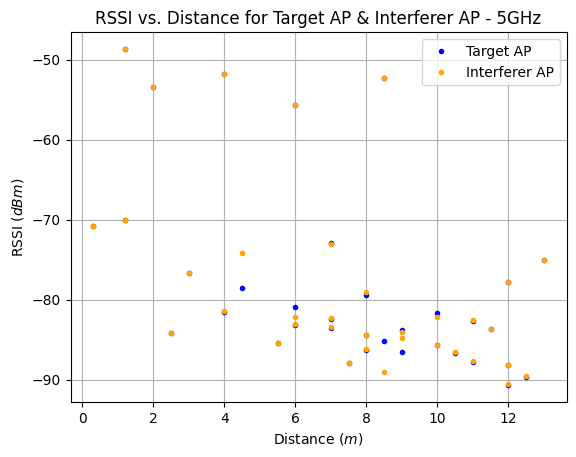

In [187]:
# Compare with interferer APs - 5 GHz

rssi_alt_5 = np.array([], dtype=float)
dist_alt_5 = np.array([], dtype=float)

with open('scan_{}_eduroam.csv'.format(band[1]), mode = 'r') as file:
    csvFile = csv.reader(file)
    for lines in csvFile:    
        rssi_alt_5 = np.append(rssi_alt_5, float(lines[1]))
        dist_alt_5 = np.append(dist_alt_5, float(lines[2]))
    data = [rssi_alt_5, dist_alt_5]

plt.plot(dist_alt_5, rssi[1], '.', color='blue')
plt.plot(dist_alt_5, rssi_alt_5, '.', color='orange')
plt.xlabel('Distance ($m$)')
plt.ylabel('RSSI ($dBm$)')
plt.title('RSSI vs. Distance for Target AP & Interferer AP - 5GHz')
plt.legend(['Target AP', 'Interferer AP'])
plt.grid()
plt.show()